[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson2/hometask/HH-api-hometask.ipynb)

# Задание
* Скачать все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, а также captcha подумайте как их можно обойти)
* Извлеките все описания этих вакансий
* Создайте аналогичный vacancy DataFrame только добавьте поле skills
* Переведите даты публикаций в datetime
* Постройте график опубликованных вакансий по датам
* Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
* Найдите те вакансии с использованием python, которые вам интересны
* Определите по полю skills какие навыки больше всего востребованы для этих вакансий
* Постройте график наиболее востребованных навыков для аналитика данных

https://github.com/hhru/api

In [1]:
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np
import time
from functools import reduce

In [2]:
sber = '3529'
page = 1
num_per_page = 50
moscow = 1
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'

In [3]:
url

'https://api.hh.ru/vacancies?employer_id=3529&page=1&per_page=50&area=1'

In [4]:
res = requests.get(url)

In [5]:
count_page=res.json().get('pages')
count_vac=res.json().get('found')

print('Всего страниц в запросе: '+ str(count_page))
print(f"Всего найдено {count_vac} вакансий")



Всего страниц в запросе: 25
Всего найдено 1214 вакансий


In [6]:
%%time
## Данные о вакансиях

vacancies = []

for page in tqdm(range(count_page)):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    vacancies += res.json()['items']
    #time.sleep(3)


print(f'Скачали {len(vacancies)} вакансии. Найденное совпадает со скаченным? {len(vacancies)==count_vac}')



  0%|          | 0/25 [00:00<?, ?it/s]

Скачали 1214 вакансии. Найденное совпадает со скаченным? True
CPU times: total: 1.25 s
Wall time: 8.6 s


In [7]:
%%time
info_vacs = []
vacancies_ids = [el['id'] for el in vacancies]

for v_id in tqdm(vacancies_ids):
    url = f'https://api.hh.ru/vacancies/{v_id}'
    vac = requests.get(url).json()
    info_vacs.append(vac)
    time.sleep(0.01) # боремся с капчей (паузой показываю, что запрашивает человек)

  0%|          | 0/1214 [00:00<?, ?it/s]

CPU times: total: 49.8 s
Wall time: 3min 48s


## Создайте аналогичный vacancy DataFrame только добавьте поле skills
## Переведите даты публикаций в datetime

In [8]:
df = pd.DataFrame()

for col in vacancies[0].keys():
    s = pd.Series([el[col] for el in vacancies])
    df[col] = s

print(f'Кол-во строк в DataFrame {df.shape[0]}')
df['skills'] = pd.Series([el['key_skills'] for el in info_vacs])

df['published_at']=pd.to_datetime(df['published_at'],format='%Y/%m/%d')
df['published_at']=df['published_at'].dt.tz_localize(None)

#df.to_excel('df_hh.xlsx')

Кол-во строк в DataFrame 1214


## Постройте график опубликованных вакансий по датам

График между датами 2022-07-04 08:57:22 и 2022-08-02 21:31:02


<AxesSubplot:>

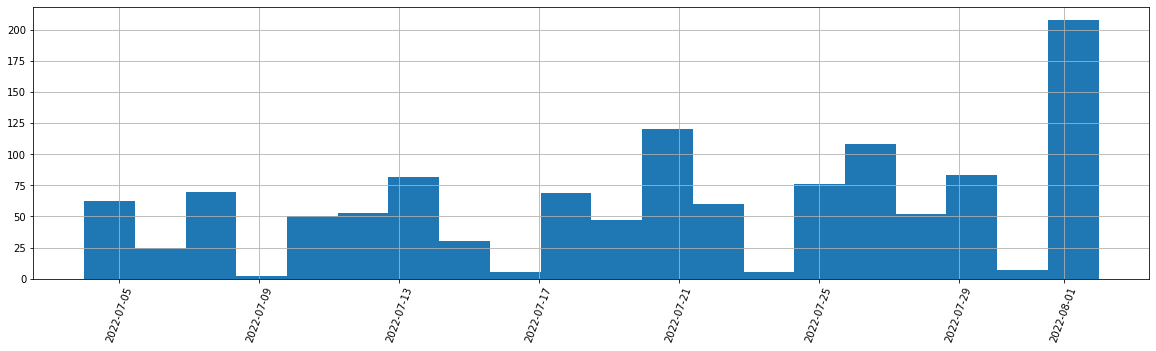

In [9]:
print(f'График между датами ' + str(df['published_at'].min()) + ' и '+ str(df['published_at'].max()))

df['published_at'].dt.date.hist(bins=20, figsize=(20, 5), xrot=70)

### Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий

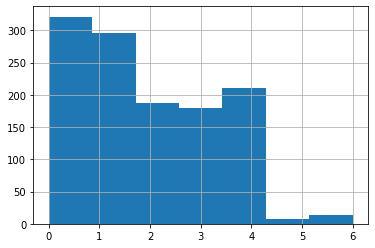

In [10]:
df['day_of_week'] = df['published_at'].dt.day_of_week.hist(bins=7)

In [11]:
df['published_at'].head(10)

0   2022-07-27 13:48:51
1   2022-07-27 11:48:44
2   2022-08-01 11:49:46
3   2022-08-02 10:44:14
4   2022-07-29 11:49:00
5   2022-08-02 16:57:19
6   2022-08-02 11:15:17
7   2022-07-19 12:11:11
8   2022-07-25 11:16:06
9   2022-07-17 16:24:19
Name: published_at, dtype: datetime64[ns]

In [12]:
print(f'Кол-во строк в DataFrame {df.shape[0]}')

Кол-во строк в DataFrame 1214


### Найдите те вакансии с использованием python, которые вам интересны

In [13]:
df['skills_copy']=df['skills']

In [14]:
df['skills_copy']=df['skills_copy'].apply(lambda s: ','.join([x.get('name') for x in s]))
df['skills_copy']=df['skills_copy'].str.lower()

In [15]:
df['name']=df['name'].str.lower()
df2=df[df['name'].str.contains('data analyst|аналитик данных|data engineer', na=False)]

In [16]:
#df[['area','skills_copy']][(df['skills_copy'].str.=='sql'.upper())]
C=df2[['area','skills_copy']][df2['skills_copy'].str.contains('sql|python', na=False)].count()[0]
print(f'Кол-во интересных мне вакансий по анализу данных с навыками SQL и Python {C}')

Кол-во интересных мне вакансий по анализу данных с навыками SQL и Python 31


### Постройте график наиболее востребованных навыков для аналитика данных
(какша, но получилось)

In [17]:
res = []
for x in df2['skills'].tolist():
    res.extend(x if isinstance(x, list) else [x])

In [18]:
all_skills = pd.Series(res)
print(all_skills.value_counts()[all_skills.value_counts() > 1])


{'name': 'Python'}           25
{'name': 'SQL'}              23
{'name': 'Hadoop'}           18
{'name': 'Spark'}            17
{'name': 'SCALA'}             9
{'name': 'Git'}               8
{'name': 'Java'}              8
{'name': 'Big Data'}          7
{'name': 'Hive'}              6
{'name': 'PostgreSQL'}        5
{'name': 'Анализ данных'}     4
{'name': 'hadoop'}            3
{'name': 'ORACLE'}            3
{'name': 'Teradata'}          3
{'name': 'kafka'}             2
{'name': 'Linux'}             2
{'name': 'ETL'}               2
{'name': 'Numpy'}             2
{'name': 'Pandas'}            2
{'name': 'Bash'}              2
{'name': 'MS SQL'}            2
dtype: int64
